In [29]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import ipywidgets as widgets

# %matplotlib inline


def normalize(array, maximum=None):
    if maximum is None:
        maximum = array.max()
    normalized = array / maximum
    return normalized



def correction_channel(channel, func):
    np_func = np.vectorize(func)
    channel = np_func(channel)
    return channel


def merge_normalized_channels(channels, need_normalize=True):
    theshold = np.vectorize(lambda x: min(1.0, x))
    new_image = []
    for c in channels:
        channel = c
        if need_normalize:
            channel = normalize(channel) * 255
        new_image.append(channel.astype('uint8'))
        
    return cv2.merge(new_image)


def split_to_normalized_channels(input_image):
    b, g, r = cv2.split(input_image)
    return b.astype('uint16'), g.astype('uint16'), r.astype('uint16')
#     return b, g, r


def color_correction_by_reference_color(image, target_color, selected_color):
    b, g, r = split_to_normalized_channels(image)

    b = b / target_color[0] * selected_color[0]
    g = g / target_color[1] * selected_color[1]
    r = r / target_color[2] * selected_color[2]
    
    round_vect = np.vectorize(round)
    b = round_vect(b / max(b.max(), 255) * 255)
    g = round_vect(g / max(g.max(), 255) * 255)
    r = round_vect(r / max(r.max(), 255) * 255)

    corrected_image = merge_normalized_channels((b, g, r), need_normalize=False)
    return corrected_image


def color_correction_by_gray_world(image):
    b, g, r = cv2.split(original_image)
    
    avg_b = np.average(b)
    avg_g = np.average(g)
    avg_r = np.average(r)
    avg_all = (avg_b + avg_g + avg_r) / 3

    coefs = np.array((avg_b, avg_g, avg_r)) / avg_all
    round_vect = np.vectorize(round)
    
    b = round_vect(b / coefs[0])
    g = round_vect(g / coefs[1])
    r = round_vect(r / coefs[2])
    
    return merge_normalized_channels((b, g, r), need_normalize=False)
    
    
def color_correction_by_func(image, func):
    b, g, r = split_to_normalized_channels(image)
    b = correction_channel(normalize(b, 255), func) * 255
    g = correction_channel(normalize(g, 255), func) * 255
    r = correction_channel(normalize(r, 255), func) * 255

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_normalizing_hist(image):
    b, g, r = split_to_normalized_channels(image)

    b = normalize(b - b.min()) * 255
    g = normalize(g - g.min()) * 255
    r = normalize(r - r.min()) * 255

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def color_correction_by_normalize_hist_in_hsv(image):
    h, s, l = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))

    l = normalize(l - l.min()) * 255

    merged = np.dstack((h, s, l)).astype('uint8')
    corrected_image = cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)
    return corrected_image


def equalize(pixel, sdf, count, gray_levels):
    sdf_min = sdf.min()
    return round(sdf[pixel] / count * (gray_levels - 1))


def equalize_channel(channel):
    gray_levels = 256
    pixel_count = len(channel) * len(channel[0])
    histogram, _ = np.histogram(channel, bins=gray_levels)
    
    sdf = histogram.cumsum()
    
    equalize_histogram = np.vectorize(lambda x: equalize(x, sdf, pixel_count, gray_levels))
    channel = equalize_histogram(channel)
    return channel


def color_correction_by_equalizing_histogram_in_hsv(image):
    h, s, l = cv2.split(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    l = equalize_channel(l)
    merged = np.dstack((h, s, l)).astype('uint8')
    corrected_image = cv2.cvtColor(merged, cv2.COLOR_HSV2BGR)
    return corrected_image


def color_correction_by_equalizing_histogram_in_rgb(image):
    b, g, r = split_to_normalized_channels(image)
    
    b = equalize_channel(b)
    g = equalize_channel(g)
    r = equalize_channel(r)

    corrected_image = merge_normalized_channels((b, g, r))
    return corrected_image


def get_histogram(image):
    pixels = list(image)
    histogram = [0 for i in range(256)]
    for pixel in pixels:
        histogram[int(pixel)] += 1
    return histogram


def plot_hist(image):
    gray_levels = 256
    names = range(gray_levels)
    r, g, b = cv2.split(image)
    
    r_hist, _ = np.histogram(r, bins=gray_levels)
    g_hist, _ = np.histogram(g, bins=gray_levels)
    b_hist, _ = np.histogram(b, bins=gray_levels)
    
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(16, 2))
    
    ax1.bar(names, r_hist, color='red', width=1.0)
    ax1.set_title('red channel')
    
    ax2.bar(names, g_hist, color='red', width=1.0)
    ax2.set_title('green channel')
    
    ax3.bar(names, b_hist, color='red', width=1.0)
    ax3.set_title('blue channel')
    
    plt.show()

    
def plot_images(first, second, need_histogram=False):
    print('Original and corrected images')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 10))
    
    ax1.imshow(cv2.cvtColor(first, cv2.COLOR_BGR2RGB))
    ax2.imshow(cv2.cvtColor(second, cv2.COLOR_BGR2RGB))

    plt.show()
    
    if need_histogram:
        print('Original image histogram (in RGB)')
        plot_hist(cv2.cvtColor(first, cv2.COLOR_BGR2RGB))
        print('Corrected image histogram (in RGB)')
        plot_hist(cv2.cvtColor(second, cv2.COLOR_BGR2RGB))

# Загрузка изображения

# Цветовая коррекция изображений

## Коррекция с опорным цветом

Original and corrected images


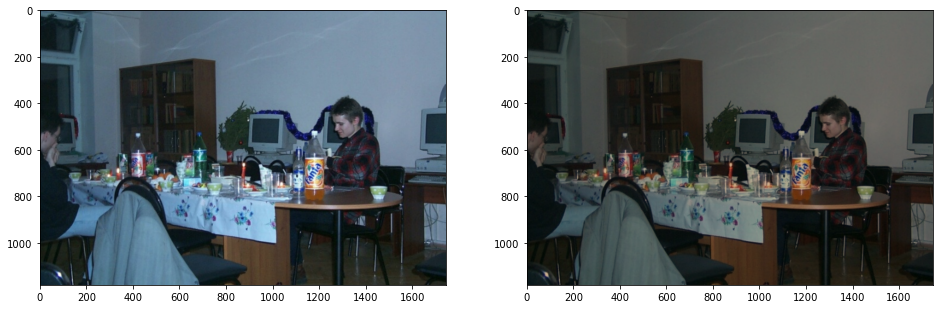

In [30]:
destination_color = (235, 225, 230)
source_color = (135, 155, 185)


original_image = cv2.imread('img/wall2.png')

corrected_image = color_correction_by_reference_color(
    original_image, destination_color, source_color)

plot_images(original_image, corrected_image)

## Серый мир

Original and corrected images


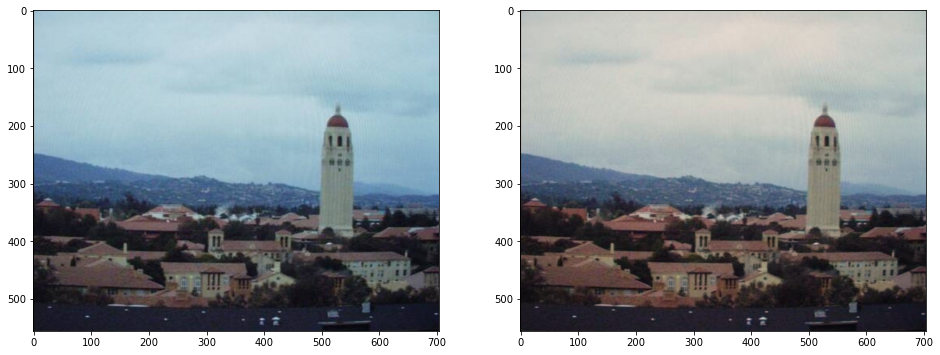

In [3]:
original_image = cv2.imread('img/example1.jpg')
corrected_image = color_correction_by_gray_world(original_image)

plot_images(original_image, corrected_image)

## По виду функции преобразования

## x^2 и sqrt(x^2)

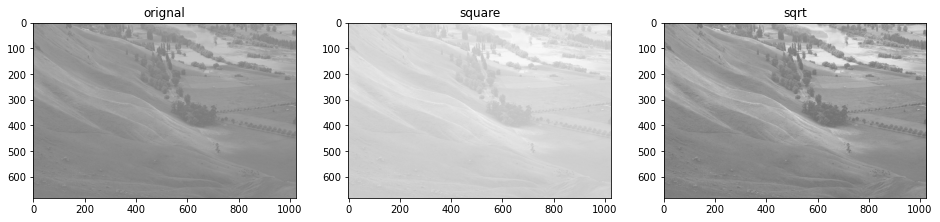

In [4]:
original_image = cv2.imread('img/mountain4.jpg')

square = lambda x: x**3
sqrt = lambda x: math.sqrt(x)

squared = color_correction_by_func(original_image, sqrt)
sqrted = color_correction_by_func(squared, square)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8))

ax1.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
ax1.set_title('orignal')

ax2.imshow(cv2.cvtColor(squared, cv2.COLOR_BGR2RGB))
ax2.set_title('square')

ax3.imshow(cv2.cvtColor(sqrted, cv2.COLOR_BGR2RGB))
ax3.set_title('sqrt')

plt.show()

### math.sqrt(x)* 10

Original and corrected images


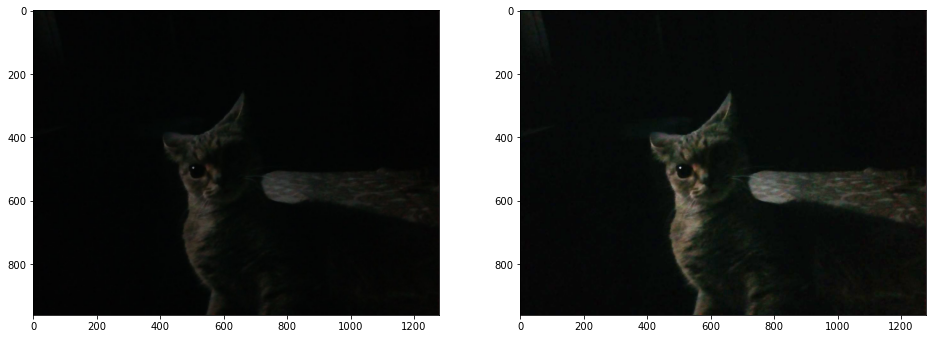

In [5]:
original_image = cv2.imread('img/night3.jpeg')

bad_function = lambda x: 2 * math.log(x + 1)
corrected_image = color_correction_by_func(original_image, bad_function)

plot_images(original_image, corrected_image)

### x**1.154

Original and corrected images


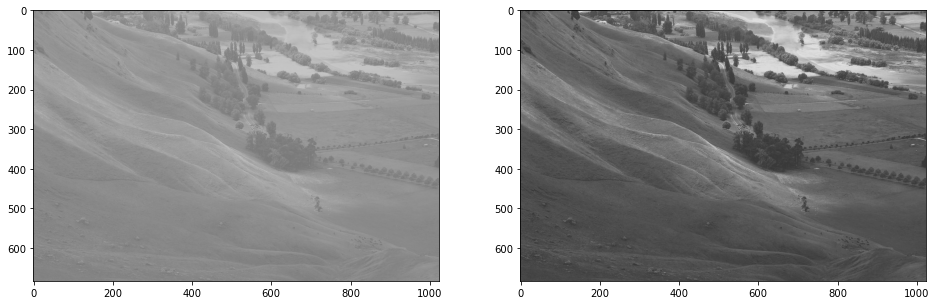

In [6]:
original_image = cv2.imread('img/mountain4.jpg')
good_function = lambda x: x**2.8
corrected_image = color_correction_by_func(original_image, good_function)

plot_images(original_image, corrected_image)

# Коррекция на основе гистограммы
## Нормализация гистограммы
### RGB

Original and corrected images


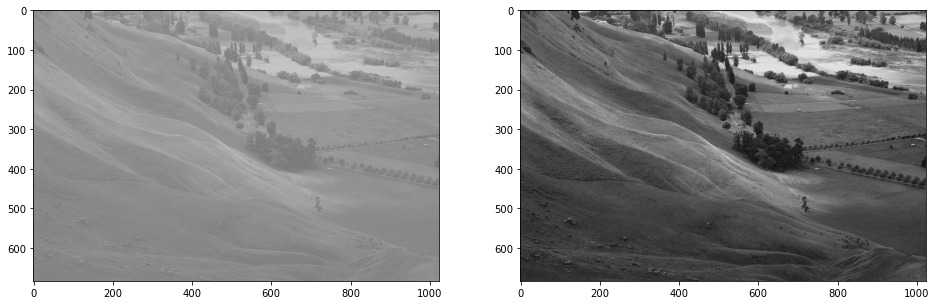

Original image histogram (in RGB)


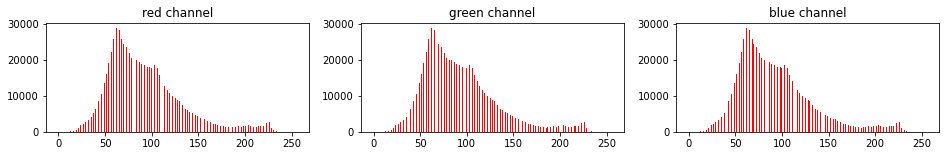

Corrected image histogram (in RGB)


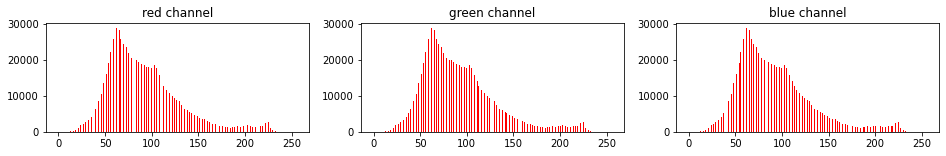

In [7]:
original_image = cv2.imread('img/mountain4.jpg')

corrected_image = color_correction_by_normalizing_hist(original_image)
very_good_for_thres = corrected_image
plot_images(original_image, corrected_image, need_histogram=True)

### HSV

Original and corrected images


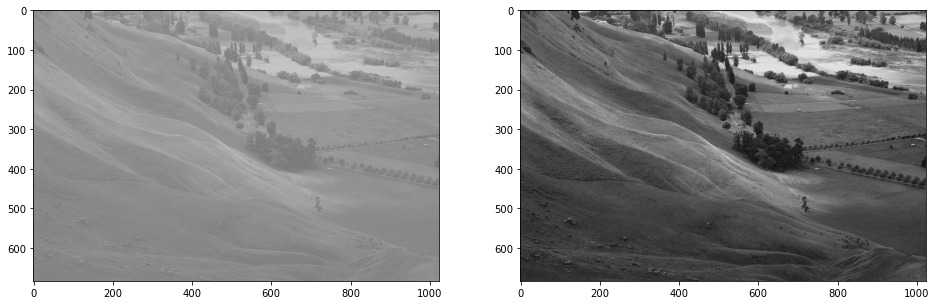

Original image histogram (in RGB)


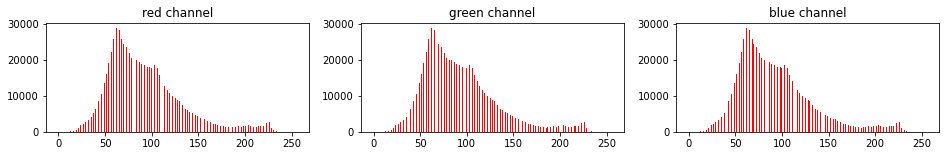

Corrected image histogram (in RGB)


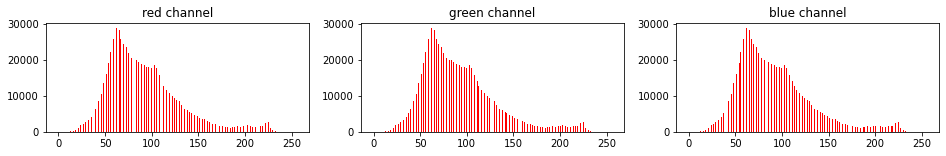

In [8]:
original_image = cv2.imread('img/mountain4.jpg')
corrected_image = color_correction_by_normalize_hist_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Эквализация гистограммы

### RGB

Original and corrected images


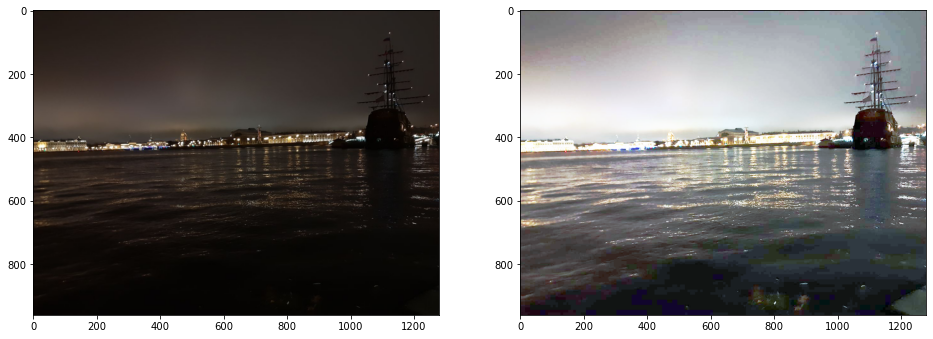

Original image histogram (in RGB)


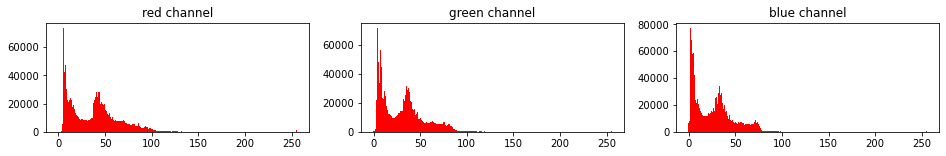

Corrected image histogram (in RGB)


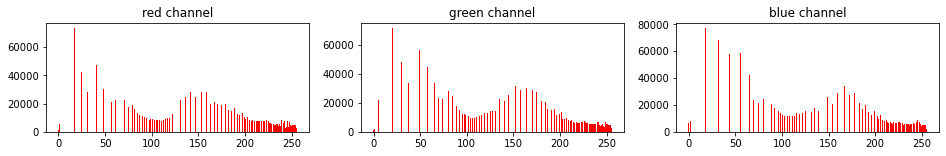

In [9]:
original_image = cv2.imread('img/night4.jpeg')
corrected_image = color_correction_by_equalizing_histogram_in_rgb(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


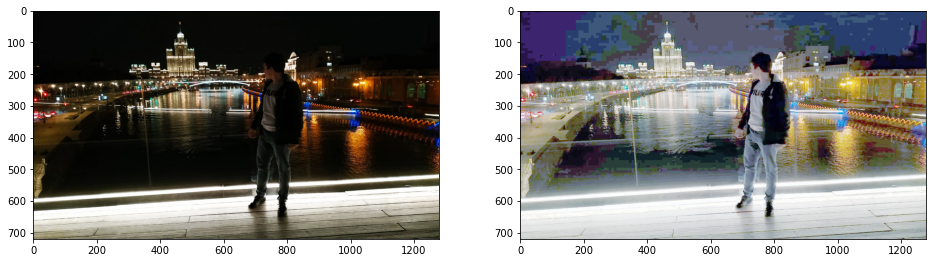

Original image histogram (in RGB)


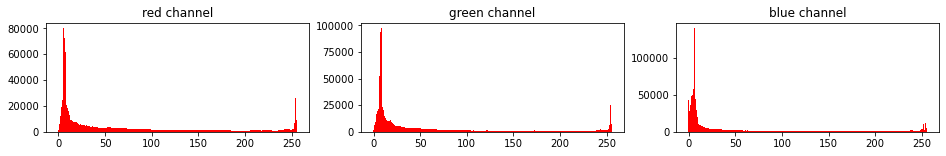

Corrected image histogram (in RGB)


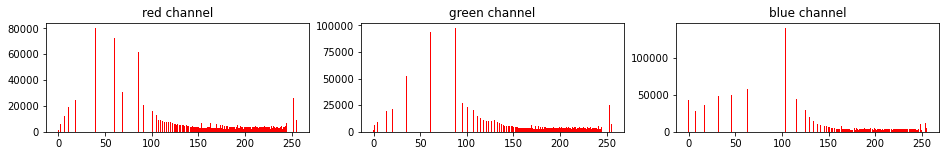

In [10]:
original_image = cv2.imread('img/moscow1.jpg')

corrected_image = color_correction_by_equalizing_histogram_in_rgb(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


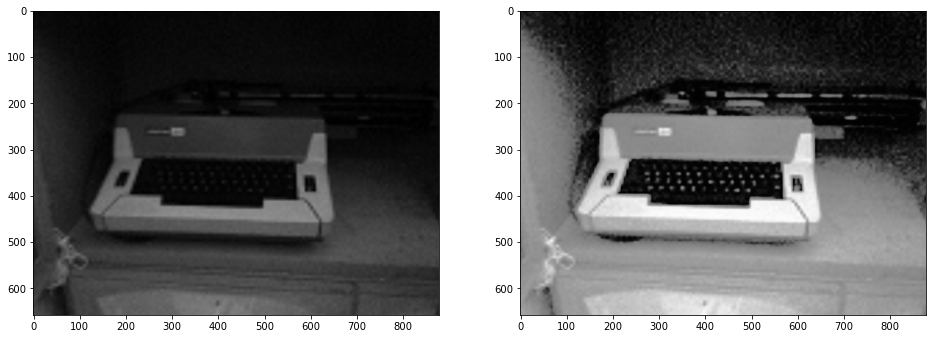

Original image histogram (in RGB)


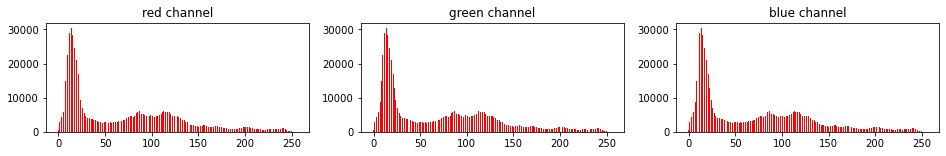

Corrected image histogram (in RGB)


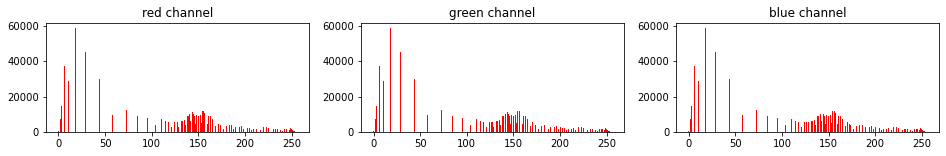

In [11]:
original_image = cv2.imread('img/printer1.png')

corrected_image = color_correction_by_equalizing_histogram_in_rgb(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

### HSV

Original and corrected images


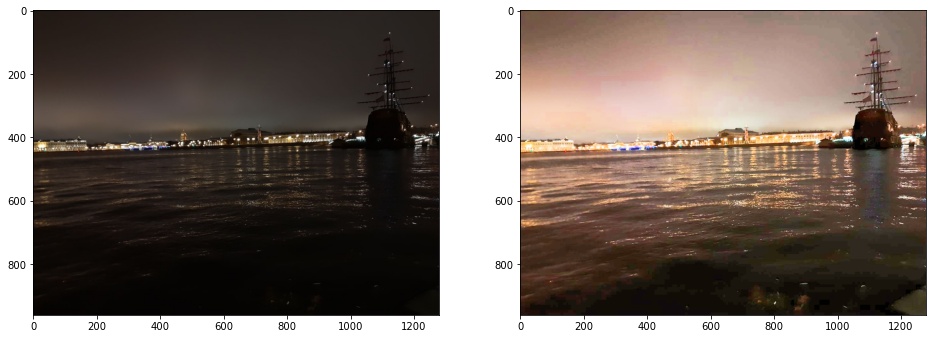

Original image histogram (in RGB)


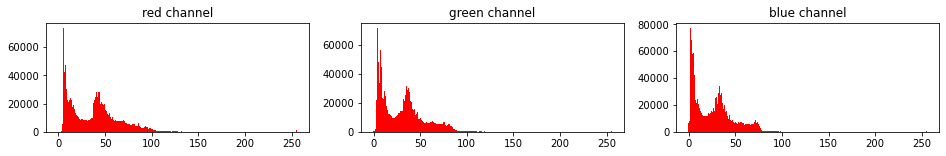

Corrected image histogram (in RGB)


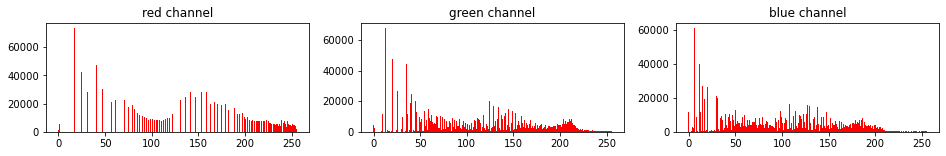

In [12]:
original_image = cv2.imread('img/night4.jpeg')

corrected_image = color_correction_by_equalizing_histogram_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


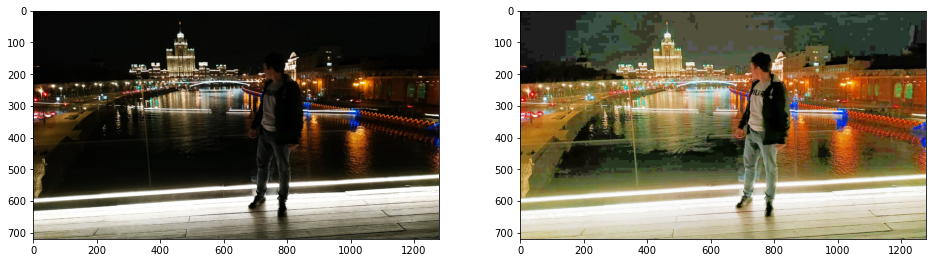

Original image histogram (in RGB)


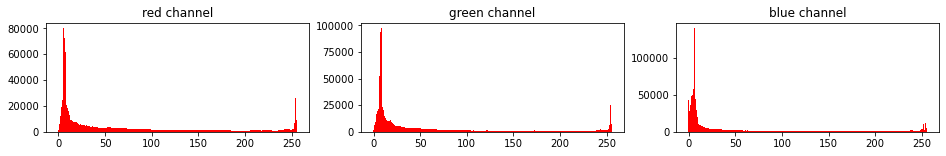

Corrected image histogram (in RGB)


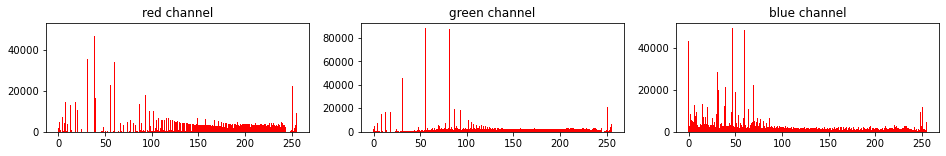

In [13]:
original_image = cv2.imread('img/moscow1.jpg')
corrected_image = color_correction_by_equalizing_histogram_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


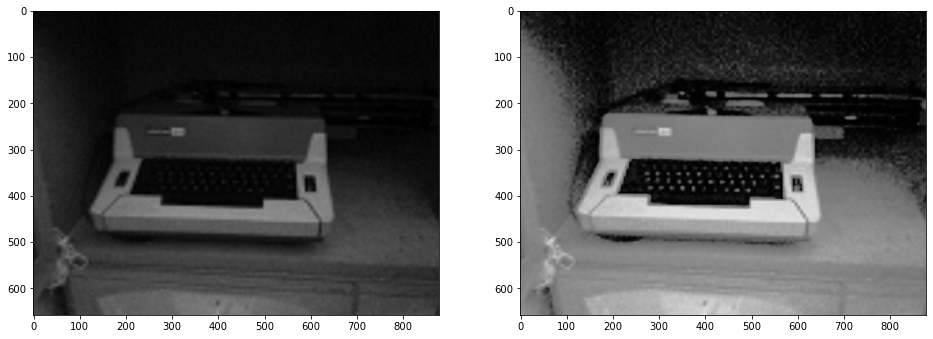

Original image histogram (in RGB)


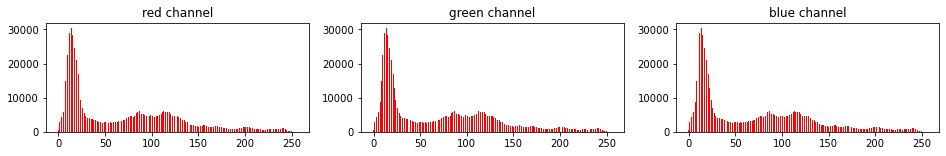

Corrected image histogram (in RGB)


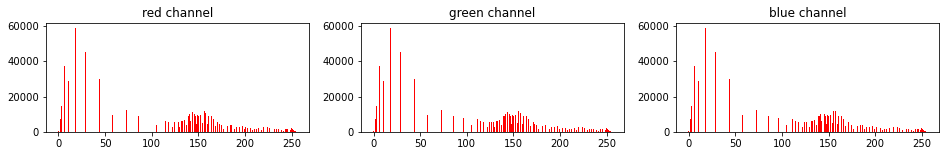

In [14]:
original_image = cv2.imread('img/printer1.png')
corrected_image = color_correction_by_equalizing_histogram_in_hsv(original_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Преобразование + нормализация гистограммы

Original and corrected images


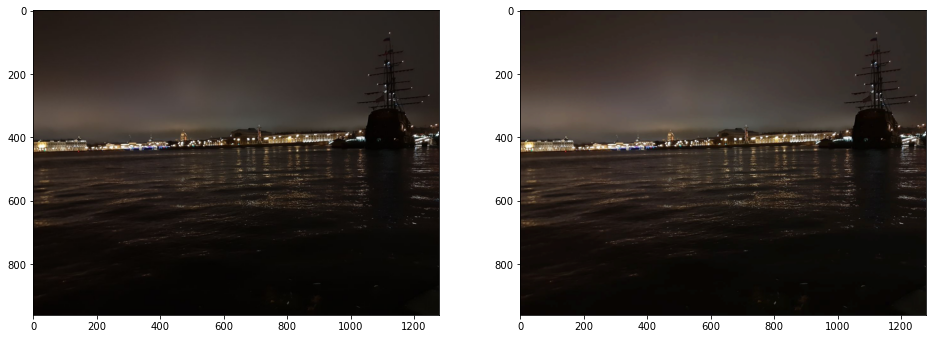

Original image histogram (in RGB)


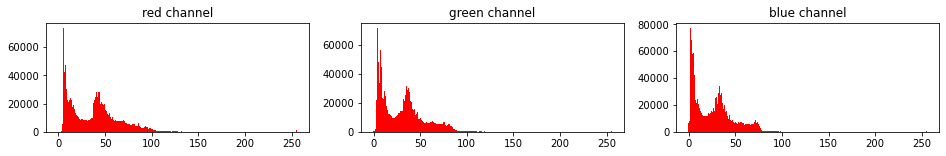

Corrected image histogram (in RGB)


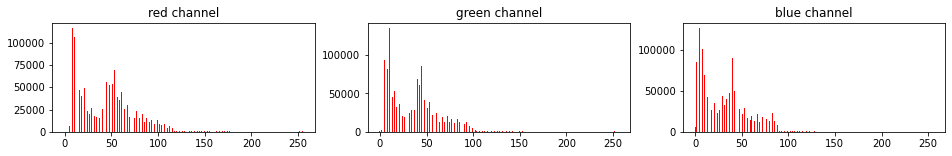

In [15]:
original_image = cv2.imread('img/night4.jpeg')

function = lambda x: math.log(x + 2) * 25
corrected_image = color_correction_by_func(original_image, function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


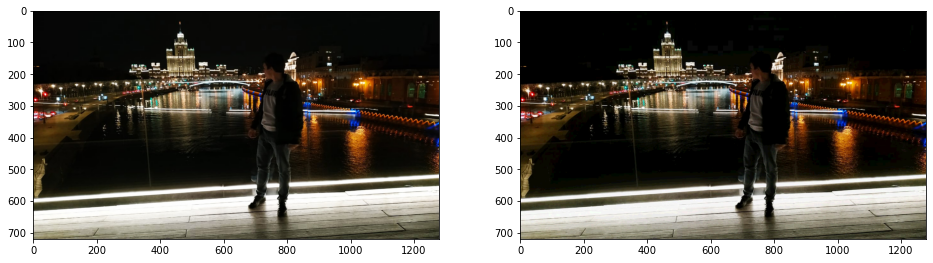

Original image histogram (in RGB)


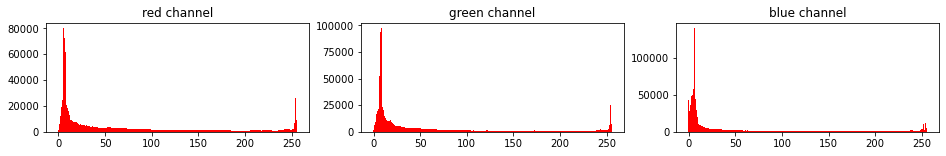

Corrected image histogram (in RGB)


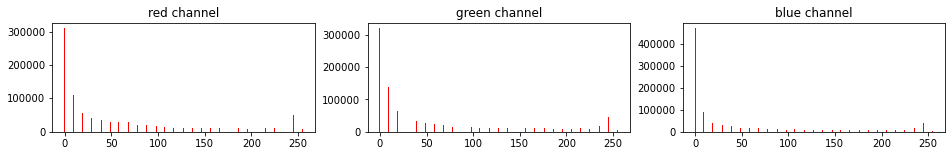

In [16]:
original_image = cv2.imread('img/moscow1.jpg')

function = lambda x: math.log(x + 5) * 25
corrected_image = color_correction_by_func(original_image, function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


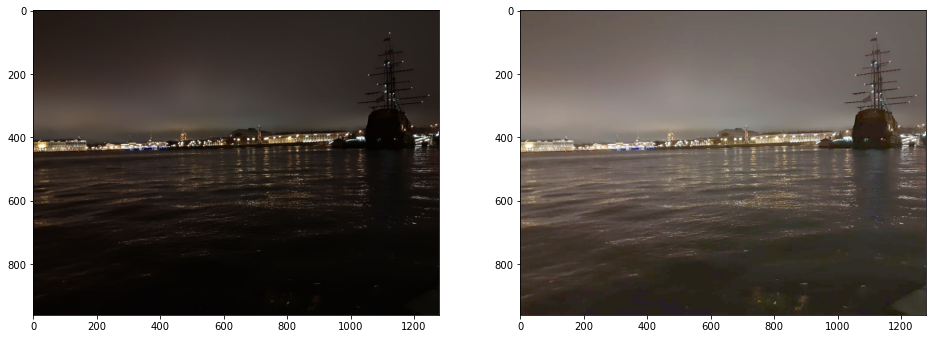

Original image histogram (in RGB)


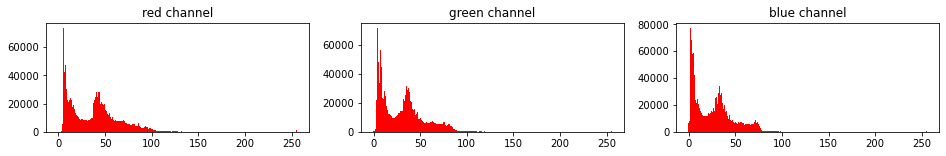

Corrected image histogram (in RGB)


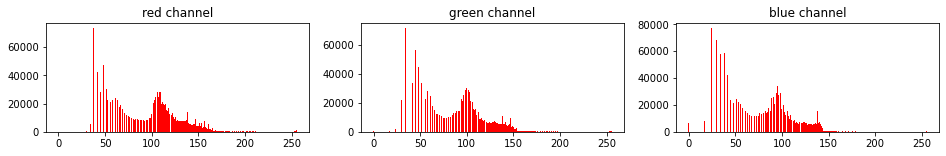

In [17]:
original_image = cv2.imread('img/night4.jpeg')

bad_function = lambda x: 15 * x**0.48
corrected_image = color_correction_by_func(original_image, bad_function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

Original and corrected images


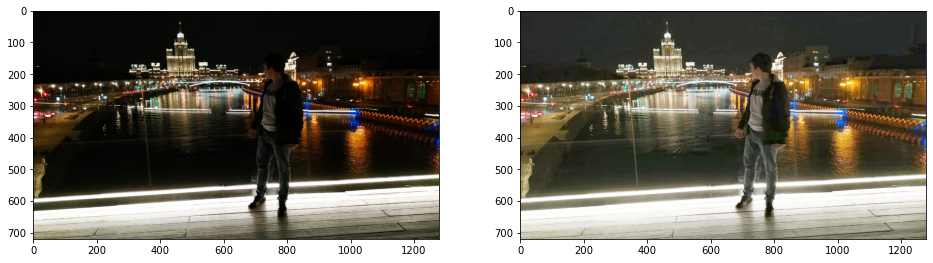

Original image histogram (in RGB)


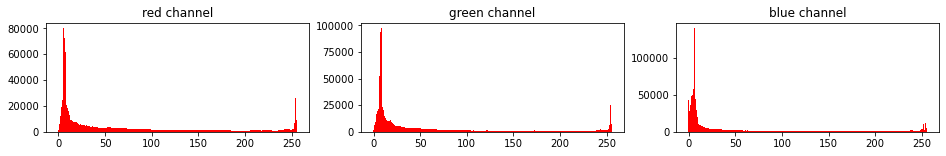

Corrected image histogram (in RGB)


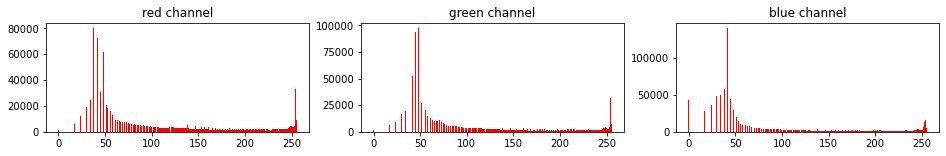

In [18]:
original_image = cv2.imread('img/moscow1.jpg')

bad_function = lambda x: 15 * x**0.48
corrected_image = color_correction_by_func(original_image, bad_function)
corrected_image = color_correction_by_normalizing_hist(corrected_image)

plot_images(original_image, corrected_image, need_histogram=True)

## Threshold

In [19]:
img = cv2.imread('img/document_photo.jpeg')
cv2.imshow("img",img) 

#-----Converting image to LAB Color model----------------------------------- 
lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
cv2.imshow("lab",lab)

#-----Splitting the LAB image to different channels-------------------------
l, a, b = cv2.split(lab)
cv2.imshow('l_channel', l)
cv2.imshow('a_channel', a)
cv2.imshow('b_channel', b)

#-----Applying CLAHE to L-channel-------------------------------------------
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
cl = clahe.apply(l)
cv2.imshow('CLAHE output', cl)

#-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
limg = cv2.merge((cl,a,b))
cv2.imshow('limg', limg)

#-----Converting image from LAB Color model to RGB model--------------------
final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
# plt.figure(figsize=(16,10))
# plt.imshow(final)

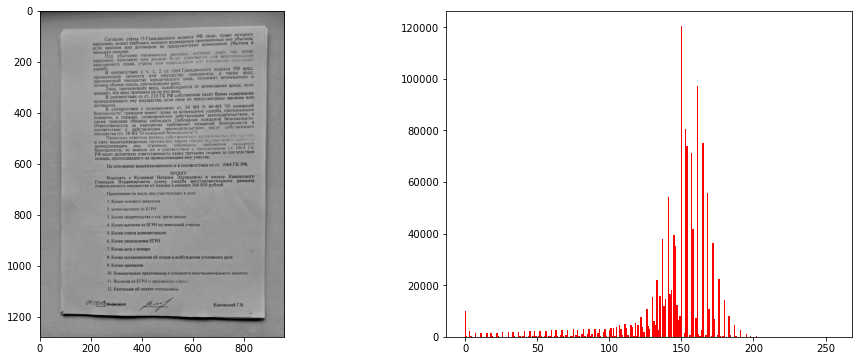

IntSlider(value=127, continuous_update=False, description='up', max=255)

IntSlider(value=0, continuous_update=False, description='down', max=255)

IntSlider(value=255, continuous_update=False, description='to', max=255)

ToggleButton(value=False, description='inverted')

In [20]:
from IPython.display import clear_output

def threshold(grays, down, up, to, inverted=False):
    tmp = grays.copy()
    
    condition = None
    if inverted:
        condition = (tmp < down) | (tmp > up) 
    else:
        condition = (tmp > down) & (tmp < up) 
    
    tmp[condition] = to
    return tmp
    
original_image = cv2.imread('img/document_photo_2.jpeg')
original_image = color_correction_by_normalize_hist_in_hsv(original_image)

gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
histogram, _ = np.histogram(gray_image, bins=256)


fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(gray_image, cmap='gray')
ax[1].bar(range(256), histogram, color='red', width=1.0)
plt.show()

params = {
    'up': 127, 'down': 0, 'to': 255, 'inverted': False
}

sliderUp = widgets.IntSlider(min=0, max=255, value=params['up'], description='up', continuous_update=False)
sliderDown = widgets.IntSlider(min=0, max=255, value=params['down'], description='down', continuous_update=False)
sliderTo = widgets.IntSlider(min=0, max=255, value=params['to'], description='to', continuous_update=False)
checkInverted = widgets.ToggleButton(value=params['inverted'], description='inverted')


def handle_slider_change(image, change):
    clear_output(wait=True)
    params[change['owner'].description] = change['new']
    image = threshold(image, params['down'], params['up'], params['to'], params['inverted'])
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].imshow(image, cmap='gray')
    ax[1].bar(range(256), histogram, color='red', width=1.0)
    plt.show()
    display(sliderUp, sliderDown, sliderTo, checkInverted)

    
sliderUp.observe(lambda change: handle_slider_change(gray_image, change), names='value')
sliderDown.observe(lambda change: handle_slider_change(gray_image, change), names='value')
sliderTo.observe(lambda change: handle_slider_change(gray_image, change), names='value')
checkInverted.observe(lambda change: handle_slider_change(gray_image, change), names='value')

display(sliderUp, sliderDown, sliderTo, checkInverted)